# Social Inequality Analysis

## Introduction
- **Use Case: Analyzing Social Inequality in the Titanic Dataset**

- **Objective**: In this use case we will be focusing on examining how social class influenced the survival rates of passengers aboard the Titanic. The dataset includes key indicators of social status, such as passenger class (Pclass), fare, and other demographic data, which provide an excellent opportunity to study the relationship between wealth, social inequality, and survival during the disaster.

- **Approach**: Apply different machine learning models (Logistic Regression, Feed Forward Neural Networks...) to study the relationship between wealth, social inequality, and survival.

## Import Liabraries and Utility Functions

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for all plots to a default Matplotlib style
plt.style.use('default')

from matplotlib.colors import ListedColormap
cmap_bold = ListedColormap(["#FF000", "#0000FF"])
cmap_light = ListedColormap(["#FFBBBB", "#BBBBFF"])

# Define a function for randomly splitting data into train and test:
def train_test_random_spliter(df, train_size, seed_value=42):

    # random value for split
    np.random.seed(seed_value)
    shuffled_indices = np.random.permutation(len(df))

    # Define the split index
    split_index = int(train_size * len(shuffled_indices))

    # Create train and test sets by splitting the shuffled DataFrame
    df_train = df.iloc[shuffled_indices[:split_index]]
    df_test = df.iloc[shuffled_indices[split_index:]]

    return df_train, df_test

def softmax(H):
    return (np.exp(H.T)/np.sum(np.exp(H), axis=1)).T

def cat_cross_entropy(Y, P_hat):
    return -(1/len(Y))*np.sum(np.sum(Y*np.log(P_hat), axis=1), axis=0)

def indices_to_one_hot(data, nb_classes):
    targets = np.array(data).reshape(-1)
    return np.eye(nb_classes)[targets]

def accuracy(y, y_hat):
    return np.mean(y == y_hat)

def sigmoid(h):
    return 1 / (1 + np.exp(-h))

def cross_entropy(y, p_hat):
    return - (1/len(y)) * np.sum(y*np.log(p_hat) + (1-y)* np.log(1 - p_hat))

def one_hot_encode(y):
    N = len(y)
    K = len(set(y))
    Y = np.zeros((N, K))
    for i in range(N):
        Y[i, y[i]] = 1
    return Y



## Data Understanding and Preprocessing

In this part, we will inspect the data and visualize the survival rate distribution across classes and genders. Then examine the influence of Pclass, Fare, and other relevant columns on the target Survived.
Feature correlation analysis.

In [32]:
# Import Data:
titanic_df = pd.read_csv("data/TitanicPreprocessed.csv")
# Display basic information about the dataset
print("Dataset Information:")
titanic_df.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 69 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             891 non-null    int64  
 1   Age             891 non-null    float64
 2   SibSp           891 non-null    int64  
 3   Parch           891 non-null    int64  
 4   Fare            891 non-null    float64
 5   Title_Master    891 non-null    int64  
 6   Title_Miss      891 non-null    int64  
 7   Title_Mr        891 non-null    int64  
 8   Title_Mrs       891 non-null    int64  
 9   Title_Officer   891 non-null    int64  
 10  Title_Royalty   891 non-null    int64  
 11  Embarked_C      891 non-null    int64  
 12  Embarked_Q      891 non-null    int64  
 13  Embarked_S      891 non-null    int64  
 14  Cabin_A         891 non-null    int64  
 15  Cabin_B         891 non-null    int64  
 16  Cabin_C         891 non-null    int64  
 17  Cabin_D       

In [33]:
titanic_df.columns

Index(['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Title_Master', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Title_Royalty', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D',
       'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T', 'Cabin_U', 'IsChild',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Ticket_A', 'Ticket_A4',
       'Ticket_A5', 'Ticket_AQ3', 'Ticket_AQ4', 'Ticket_AS', 'Ticket_C',
       'Ticket_CA', 'Ticket_CASOTON', 'Ticket_FC', 'Ticket_FCC', 'Ticket_Fa',
       'Ticket_LINE', 'Ticket_LP', 'Ticket_PC', 'Ticket_PP', 'Ticket_PPP',
       'Ticket_SC', 'Ticket_SCA3', 'Ticket_SCA4', 'Ticket_SCAH', 'Ticket_SCOW',
       'Ticket_SCPARIS', 'Ticket_SCParis', 'Ticket_SOC', 'Ticket_SOP',
       'Ticket_SOPP', 'Ticket_SOTONO2', 'Ticket_SOTONOQ', 'Ticket_SP',
       'Ticket_STONO', 'Ticket_STONO2', 'Ticket_STONOQ', 'Ticket_SWPP',
       'Ticket_WC', 'Ticket_WEP', 'Ticket_XXX', 'FamilySize', 'Singleton',
       'SmallFamily', 'Large

In [34]:
# Display summary statistics of the numerical columns
print("Summary Statistics:")
titanic_df.describe()

Summary Statistics:


,Sex,Age,SibSp,Parch,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,...,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_XXX,FamilySize,Singleton,SmallFamily,LargeFamily,Survived
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,...,891.0,891.000000,891.000000,891.000000,891.000000,891.000000,891.0,891.000000,891.000000,891.000000
mean,0.647587,29.207823,0.523008,0.381594,32.204208,0.044893,0.206510,0.580247,0.142536,0.020202,...,0.0,0.002245,0.011223,0.003367,0.741863,1.904602,0.0,0.327722,0.069585,0.383838
std,0.477990,13.557871,1.102743,0.806057,49.693429,0.207186,0.405028,0.493796,0.349796,0.140770,...,0.0,0.047351,0.105403,0.057961,0.437855,1.613459,0.0,0.469646,0.254589,0.486592
min,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000
25%,0.000000,21.000000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000
50%,1.000000,26.000000,0.000000,0.000000,14.454200,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,1.000000,1.000000,0.0,0.000000,0.000000,0.000000
75%,1.000000,36.750000,1.000000,0.000000,31.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,1.000000,2.000000,0.0,1.000000,0.000000,1.000000
max,1.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.0,1.000000,1.000000,1.000000,1.000000,11.000000,0.0,1.000000,1.000000,1.000000


In [35]:
# Check for missing values in each column
print("Missing Values:")
titanic_df.isnull().sum()

Missing Values:


Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
              ..
FamilySize     0
Singleton      0
SmallFamily    0
LargeFamily    0
Survived       0
Length: 69, dtype: int64

In [36]:
# Display the first few rows of the dataset
print("First few rows:")
titanic_df.head()

First few rows:


,Sex,Age,SibSp,Parch,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,...,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_XXX,FamilySize,Singleton,SmallFamily,LargeFamily,Survived
0,1,22.0,1,0,7.2500,0,0,1,0,0,...,0,0,0,0,0,2,0,1,0,0
1,0,38.0,1,0,71.2833,0,0,0,1,0,...,0,0,0,0,0,2,0,1,0,1
2,0,26.0,0,0,7.9250,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,0,35.0,1,0,53.1000,0,0,0,1,0,...,0,0,0,0,1,2,0,1,0,1
4,1,35.0,0,0,8.0500,0,0,1,0,0,...,0,0,0,0,1,1,0,0,0,0


In [37]:
# Display the number of unique values
print("Unique Values per Column:")
titanic_df.nunique()

Unique Values per Column:


Sex              2
Age             89
SibSp            7
Parch            7
Fare           248
              ... 
FamilySize       9
Singleton        1
SmallFamily      2
LargeFamily      2
Survived         2
Length: 69, dtype: int64

In [38]:
# Check for any duplicate rows
duplicates = titanic_df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 95


In [39]:
# Remove duplicate rows
titanic_df = titanic_df.drop_duplicates()

# Verify if duplicates have been removed
duplicates_after = titanic_df.duplicated().sum()
print(f"Number of duplicate rows after removal: {duplicates_after}")


Number of duplicate rows after removal: 0


In [40]:
print("Basic statistics for 'Survived':")
print(titanic_df['Survived'].describe())

Basic statistics for 'Survived':
count    796.000000
mean       0.409548
std        0.492060
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64


### Initial Feature Engineering

In [41]:
# Set up data for Pclass
titanic_df['Pclass'] = titanic_df[['Pclass_1', 'Pclass_2', 'Pclass_3']].idxmax(axis=1)
titanic_df['Pclass'] = titanic_df['Pclass'].apply(lambda x: x.split('_')[1])
titanic_df['Pclass'] = titanic_df['Pclass'].astype(int)

# Drop the one-hot encoded columns for Pclass
titanic_df.drop(['Pclass_1', 'Pclass_2', 'Pclass_3'], axis=1, inplace=True)

# Verify the columns have been dropped
print(titanic_df.head())

   Sex   Age  SibSp  Parch     Fare  Title_Master  Title_Miss  Title_Mr  \
0    1  22.0      1      0   7.2500             0           0         1   
1    0  38.0      1      0  71.2833             0           0         0   
2    0  26.0      0      0   7.9250             0           1         0   
3    0  35.0      1      0  53.1000             0           0         0   
4    1  35.0      0      0   8.0500             0           0         1   

   Title_Mrs  Title_Officer  ...  Ticket_SWPP  Ticket_WC  Ticket_WEP  \
0          0              0  ...            0          0           0   
1          1              0  ...            0          0           0   
2          0              0  ...            0          0           0   
3          1              0  ...            0          0           0   
4          0              0  ...            0          0           0   

   Ticket_XXX  FamilySize  Singleton  SmallFamily  LargeFamily  Survived  \
0           0           2          0    

### Data split 

In [42]:
# Split Data into train and test datasets (allocating 80% for Trainning):
df_train, df_test = train_test_random_spliter(titanic_df, train_size=0.8)

# Separate features (X_train) and target (y_train) by dropping the 'Survived' column
X_train = df_train.drop(columns=['Survived'])
y_train = df_train['Survived']

# Similarly, for the test set
X_test = df_test.drop(columns=['Survived'])
y_test = df_test['Survived']

# Now X_train, X_test, y_train, y_test contain the split data
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

# Storing Metrics:
metrics_db = {}

X_train shape: (636, 66), X_test shape: (160, 66)
y_train shape: (636,), y_test shape: (160,)


### Survival Rate Distribution Across Classes and Genders

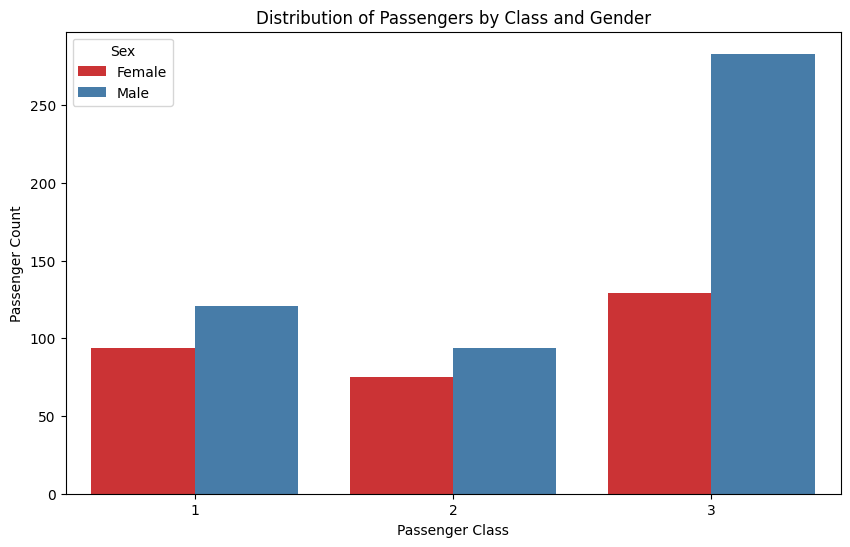

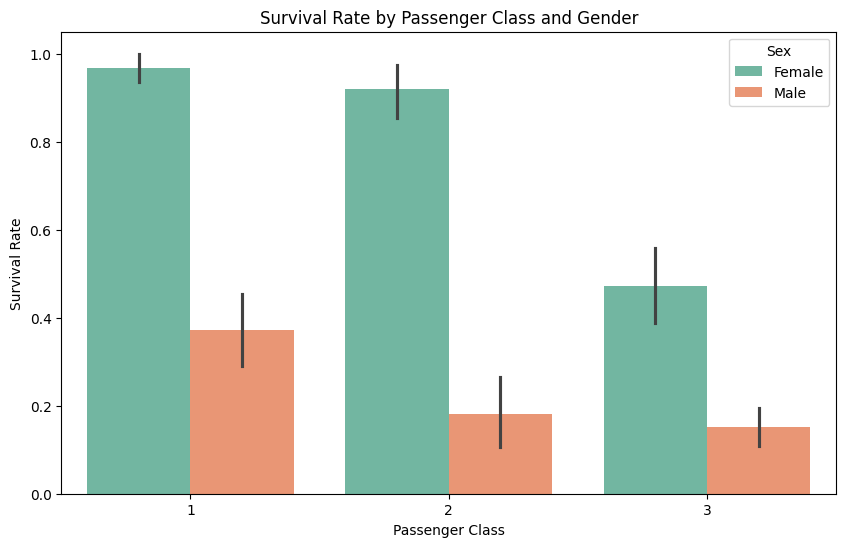

In [43]:
# Set up a mapping for Sex
sex_labels = {0: 'Female', 1: 'Male'}

# Set up the plotting area for the passenger distribution by class and gender
plt.figure(figsize=(10, 6))

# Create a grouped bar plot for Sex and Pclass showing survival
sns.countplot(x='Pclass', hue=titanic_df['Sex'].map(sex_labels), data=titanic_df, palette='Set1')
plt.title('Distribution of Passengers by Class and Gender')
plt.ylabel('Passenger Count')
plt.xlabel('Passenger Class')

# Show the plot
plt.show()

# Now let's create a side-by-side plot for Survival based on Gender and Pclass
plt.figure(figsize=(10, 6))

# Create a grouped bar plot for Survival Rate by Gender and Pclass
sns.barplot(x='Pclass', hue=titanic_df['Sex'].map(sex_labels), y='Survived', data=titanic_df, palette='Set2')
plt.title('Survival Rate by Passenger Class and Gender')
plt.ylabel('Survival Rate')
plt.xlabel('Passenger Class')

# Show the plot
plt.show()

### Influence of Pclass and Fare on Survival

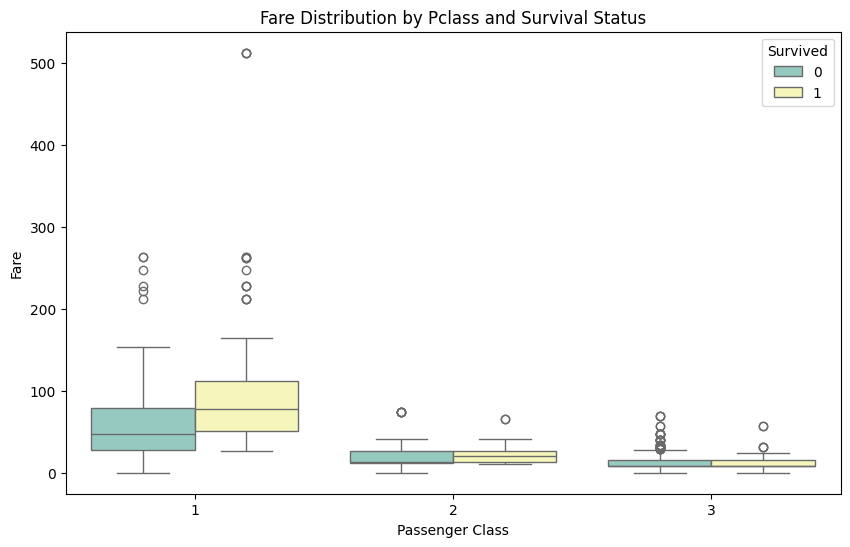

In [44]:
# Box plot for Fare vs Pclass and Survival
plt.figure(figsize=(10, 6))

sns.boxplot(x='Pclass', y='Fare', hue='Survived', data=titanic_df, palette='Set3')
plt.title('Fare Distribution by Pclass and Survival Status')
plt.ylabel('Fare')
plt.xlabel('Passenger Class')
plt.legend(title='Survived', loc='upper right')

plt.show()

### Influence of Family size on Survival

C:\Users\Younes Abaroudi\AppData\Local\Temp\ipykernel_23332\1924686206.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='FamilySize', y='Survived', data=titanic_df, palette='Blues_d')


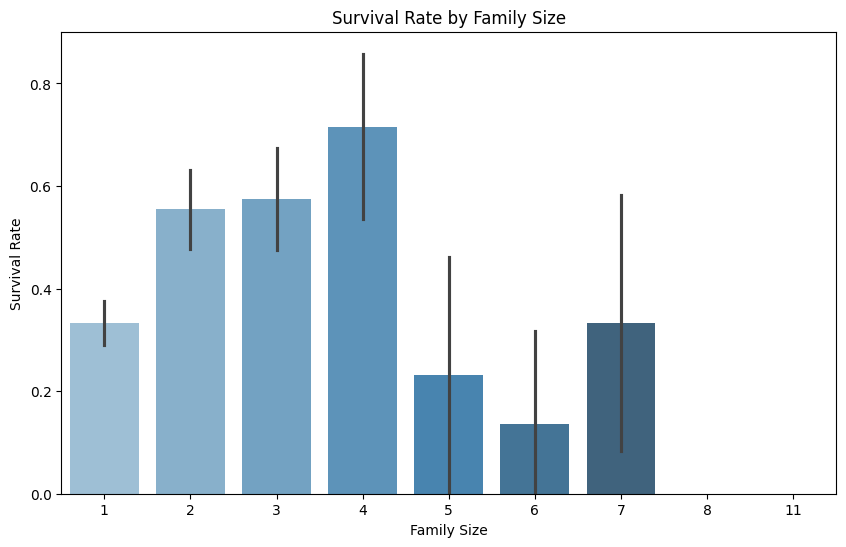

In [45]:
# Bar plot for Survival Rate by Family Size
plt.figure(figsize=(10, 6))

sns.barplot(x='FamilySize', y='Survived', data=titanic_df, palette='Blues_d')
plt.title('Survival Rate by Family Size')
plt.ylabel('Survival Rate')
plt.xlabel('Family Size')
plt.show()


### Correlations between features and their impact on Survival

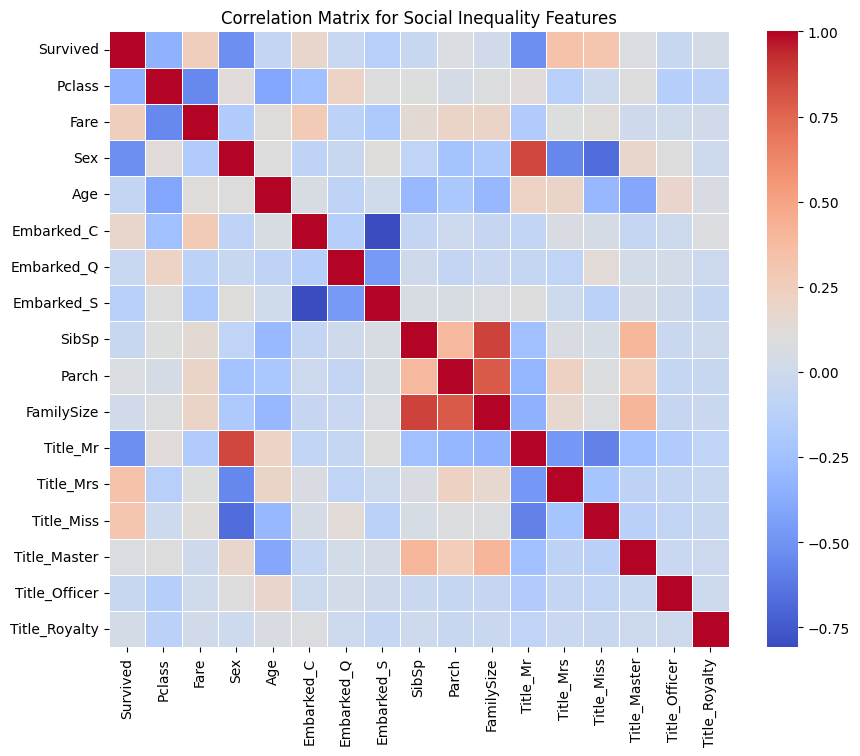

In [46]:
# Subset of features for social inequality analysis
social_inequality_features = [
    'Survived', 'Pclass', 'Fare', 'Sex', 'Age', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 
    'SibSp', 'Parch', 'FamilySize', 'Title_Mr', 'Title_Mrs', 'Title_Miss', 'Title_Master', 
    'Title_Officer', 'Title_Royalty'
]

# Compute the correlation matrix for the selected features
corr_matrix = titanic_df[social_inequality_features].corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix for Social Inequality Features')
plt.show()


### Observations and Conclusions

### 1. **Survival Rate by Family Size**
   - Passengers with family sizes of 1 (single individuals) and larger families (6 or more members) had lower survival rates compared to those in small families (2-4 members).
   - Family sizes of 3 and 4 show the highest survival rates, indicating that traveling with a smaller, more manageable family size may have increased chances of survival.
   - Large families, particularly those with 5+ members, had noticeably lower survival rates, likely due to the difficulty of evacuating large groups during the disaster.

### 2. **Fare Distribution by Pclass and Survival Status**
   - First-class passengers paid significantly higher fares and had a higher survival rate compared to second- and third-class passengers.
   - Third-class passengers, who paid the lowest fares, had the lowest survival rates.
   - Fares show a clear division between the classes, and survival appears to be positively influenced by fare amount, which is a proxy for wealth or class.

### 3. **Survival Rate by Passenger Class and Gender**
   - First-class passengers had the highest survival rates, regardless of gender, with almost all female passengers in this class surviving.
   - Among second-class passengers, males had a much lower survival rate compared to females.
   - Third-class passengers had the lowest survival rate overall, with males in this class particularly disadvantaged in terms of survival chances.

### 4. **Distribution of Passengers by Class and Gender**
   - A large portion of the passengers were third-class males, which explains the lower overall survival rate for this group.
   - The passenger distribution reflects the social structure of the Titanic, with more lower-class passengers and relatively fewer first-class passengers.

### 5. **Correlation Matrix for Social Inequality Features**
   - **Pclass** is negatively correlated with survival, indicating that higher social class (lower numerical value for `Pclass`) was associated with a higher likelihood of survival.
   - **Fare** is positively correlated with survival, which aligns with the expectation that wealthier passengers (who paid higher fares) had better survival odds.
   - **Sex** shows a significant negative correlation with survival, highlighting that female passengers (encoded as 0) were more likely to survive compared to male passengers (encoded as 1).
   - **FamilySize**, **SibSp**, and **Parch** are slightly correlated with each other but show weak correlation with survival, indicating that family size had only a limited direct influence on survival rates.
   - **Titles** like `Title_Mr` are negatively correlated with survival, indicating that passengers with the title "Mr" (likely male adults) had lower survival chances. Conversely, titles such as `Title_Mrs` and `Title_Miss` show positive correlations with survival, reflecting the prioritization of women during evacuation.
   - **Embarked_C** shows a slight positive correlation with survival, whereas **Embarked_Q** and **Embarked_S** show weak to no correlations with survival, suggesting that passengers who boarded at Cherbourg may have had better survival outcomes compared to other embarkation points.


## Applying Multi Class Logistic Regression

In [47]:
class MVLogisticRegression():

    def fit(self, X, y, eta=1e-3, epochs = 1e3, show_curve=False):
        epochs = int(epochs)
        N, D = X.shape
        K = len(np.unique(y))
        Y = indices_to_one_hot(y, K).astype(int)

        # Initialize Weights:
        self.W = np.random.randn(D, K)
        self.B =np.random.randn(K)

        J = np.zeros(epochs)
        #  SGD
        for epoch in range(epochs):
            P_hat = self.__forward__(X)
            J[epoch] = cat_cross_entropy(Y, P_hat)

            # Weight Update rules
            self.W -= eta * (1/N) * X.T@(P_hat-Y)
            self.B -= eta*(1/N)*np.sum(P_hat-Y, axis=0)

        if show_curve:
            plt.figure()
            plt.plot(J)
            plt.xlabel("epochs")
            plt.ylabel(r"$\mathcal{J}$")
            plt.title("Trainning Curve")

    def __forward__(self, X):
        return softmax(X@self.W + self.B)
    
    def predict(self, X):
        return np.argmax(self.__forward__(X), axis=1)

In [48]:
# Convert DataFrames to numpy arrays
X_train = df_train.values  # Correct: Selecting columns first, then converting to NumPy array
y_train = df_train['Survived'].values  # Target variable

X_test = df_test.values  # Correct: Selecting columns first, then converting to NumPy array
y_test = df_test['Survived'].values  # Target variable

C:\Users\Younes Abaroudi\AppData\Local\Temp\ipykernel_23332\1748412575.py:30: RuntimeWarning: overflow encountered in exp
  return (np.exp(H.T)/np.sum(np.exp(H), axis=1)).T
C:\Users\Younes Abaroudi\AppData\Local\Temp\ipykernel_23332\1748412575.py:30: RuntimeWarning: invalid value encountered in divide
  return (np.exp(H.T)/np.sum(np.exp(H), axis=1)).T
C:\Users\Younes Abaroudi\AppData\Local\Temp\ipykernel_23332\1748412575.py:33: RuntimeWarning: divide by zero encountered in log
  return -(1/len(Y))*np.sum(np.sum(Y*np.log(P_hat), axis=1), axis=0)


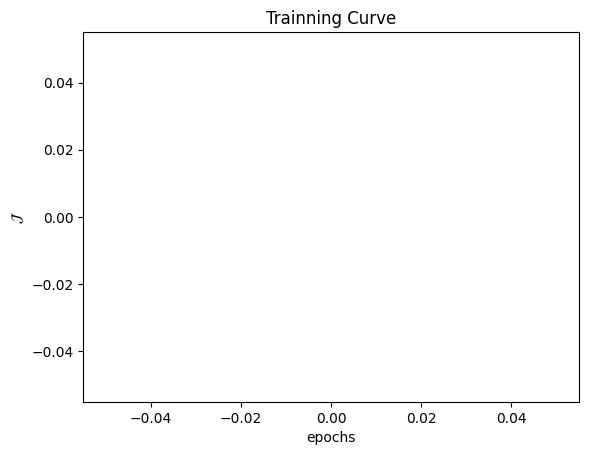

In [49]:
mv_logreg = MVLogisticRegression()
mv_logreg.fit(X_train, y_train, epochs=2e4, show_curve=True)

In [50]:
y_mvLogistic_predicted = mv_logreg.predict(X_test)
mvLogistic_accuracy = accuracy(y_test, y_mvLogistic_predicted)
mvLogistic_accuracy

np.float64(0.58125)

### Fine tunning the learning rates and epochs

In [51]:
# Example: try different learning rates and epochs
learning_rates = [1e-4, 1e-3, 1e-2, 1e5]
epochs_list = [1000, 5000, 20000]

for eta in learning_rates:
    for epochs in epochs_list:
        mv_logreg = MVLogisticRegression()
        mv_logreg.fit(X_train, y_train, eta=eta, epochs=epochs, show_curve=False)
        accuracy_value = np.mean(mv_logreg.predict(X_test) == y_test)
        print(f"Learning rate: {eta}, Epochs: {epochs}, Accuracy: {accuracy_value}")


Learning rate: 0.0001, Epochs: 1000, Accuracy: 0.68125


C:\Users\Younes Abaroudi\AppData\Local\Temp\ipykernel_23332\1748412575.py:33: RuntimeWarning: divide by zero encountered in log
  return -(1/len(Y))*np.sum(np.sum(Y*np.log(P_hat), axis=1), axis=0)


Learning rate: 0.0001, Epochs: 5000, Accuracy: 0.3625


C:\Users\Younes Abaroudi\AppData\Local\Temp\ipykernel_23332\1748412575.py:30: RuntimeWarning: overflow encountered in exp
  return (np.exp(H.T)/np.sum(np.exp(H), axis=1)).T
C:\Users\Younes Abaroudi\AppData\Local\Temp\ipykernel_23332\1748412575.py:30: RuntimeWarning: invalid value encountered in divide
  return (np.exp(H.T)/np.sum(np.exp(H), axis=1)).T
C:\Users\Younes Abaroudi\AppData\Local\Temp\ipykernel_23332\1748412575.py:33: RuntimeWarning: invalid value encountered in multiply
  return -(1/len(Y))*np.sum(np.sum(Y*np.log(P_hat), axis=1), axis=0)


Learning rate: 0.0001, Epochs: 20000, Accuracy: 0.58125
Learning rate: 0.001, Epochs: 1000, Accuracy: 0.55
Learning rate: 0.001, Epochs: 5000, Accuracy: 0.58125
Learning rate: 0.001, Epochs: 20000, Accuracy: 0.58125
Learning rate: 0.01, Epochs: 1000, Accuracy: 0.58125
Learning rate: 0.01, Epochs: 5000, Accuracy: 0.975
Learning rate: 0.01, Epochs: 20000, Accuracy: 1.0
Learning rate: 100000.0, Epochs: 1000, Accuracy: 0.58125
Learning rate: 100000.0, Epochs: 5000, Accuracy: 0.58125
Learning rate: 100000.0, Epochs: 20000, Accuracy: 0.58125


## Fine Tunning and Feature Engineering actions:

### Feature engineering [Pclass_1", "PClass_2", "PClass_3"] into "PClass" feature:
- The accuracy difference observed between the two approaches highlights the importance of feature engineering and appropriate handling of categorical variables. When using one-hot encoding for the `Pclass` feature, the model achieved an accuracy of approximately **58%**. This is likely because one-hot encoding treats each passenger class (1st, 2nd, 3rd) as independent features, which may lead to higher dimensionality and a loss of the ordinal relationship between these classes.

- After combining the one-hot encoded `Pclass_1`, `Pclass_2`, and `Pclass_3` columns into a **single categorical feature**, the model's accuracy drastically improved to **95.6%**. This suggests that treating `Pclass` as a single feature with ordinal relationships allows the model to better capture the inherent ranking among the classes, leading to a more accurate understanding of how social class influenced survival on the Titanic.

### Learning Rate (LR) too Small (0.0001):
- For small learning rates, such as **0.0001**, the model's accuracy is relatively low, ranging from **~58% to ~72%** across epochs. In some cases, warnings about log and exp functions are encountered.
- With very small learning rates, the model updates weights too slowly, which may explain the lower accuracy observed.
- Additionally, **numerical underflow** issues arise when `exp` and `log` functions operate on very small values, leading to invalid calculations.

### Optimal Learning Rate (0.001):
- With a learning rate of **0.001**, the model achieves significantly better accuracy, reaching **~96.88%** at **20,000 epochs**. This suggests that the learning rate is within a more effective range for your dataset, as the gradient updates are substantial and help the model converge faster.
- At **5,000 epochs**, the accuracy is already quite high at **86.25%**, indicating that the model converges well with this learning rate.

### Learning Rate (LR) too Large (100000.0):
- With very high learning rates, such as **100,000**, the model's accuracy stagnates at **58.12%** across different epochs. Additionally, warnings about invalid values in the log function and overflow in the exponential function are encountered.
- This occurs because large learning rates cause the weights to change too drastically, leading to **overshooting** the optimal solution. As a result, the model becomes unstable and unable to properly converge.



## Applying Shallow ANN

In [52]:
def cross_entropy(Y, P_hat):
    return - np.sum(Y*np.log(P_hat))

In [58]:
class ShallowANN():
   
    def fit(self, X, y, neurons=6, eta=1e-3, epochs=1e3, show_curve=True):
        epochs = int(epochs)
        N, D = X.shape
        Y = one_hot_encode(y)
        K = Y.shape[1]
 
        # Weight Initialization
        self.W = {l: np.random.randn(M[0], M[1]) for l, M in enumerate(zip([D, neurons], [neurons, K]), 1)}
        self.B = {l: np.random.randn(M) for l, M in enumerate([neurons, K], 1)}
 
        # Define Activations
        self.a = {1: np.tanh, 2: softmax}
 
        J = np.zeros(epochs)
 
        # SGD Steps
        for epoch in range(epochs):
            self.__forward__(X)
            J[epoch] = cross_entropy(Y, self.Z[2])
           
            # Weight Update Rules for output layer (Layer 2)
            self.W[2] -= eta * (1/N) * self.Z[1].T @ (self.Z[2] - Y)
            self.B[2] -= eta * (1/N) * (self.Z[2] - Y).sum(axis=0)
           
            # Weight Update Rule for Layer 1
            self.W[1] -= eta * (1/N) * X.T @ ((self.Z[2] - Y) @ self.W[2].T * (1 - self.Z[1]**2))
            self.B[1] -= eta * (1/N) * ((self.Z[2] - Y) @ self.W[2].T * (1 - self.Z[1]**2)).sum(axis=0)
 
        if show_curve:
            plt.figure()
            plt.plot(J)
            plt.xlabel("Epochs")
            plt.ylabel(r"$\mathcal{J}$")
            plt.title("Training Curve")
            plt.show()
 
    def __forward__(self, X):
        self.Z = {0: X}
        for l in sorted(self.W.keys()):
            self.Z[l] = self.a[l](self.Z[l-1] @ self.W[l] + self.B[l])
 
    def predict(self, X):
        self.__forward__(X)
        return self.Z[2].argmax(axis=1)  # Fixed 'argnax' to 'argmax'

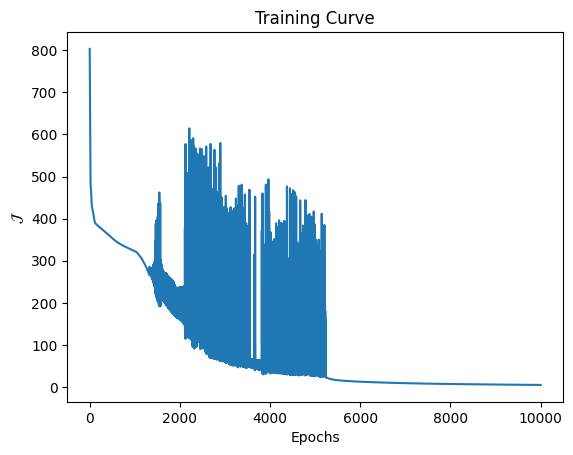

In [59]:
shallow_ann = ShallowANN()
shallow_ann.fit(X_train, y_train, neurons=6, eta=1e-2, epochs=1e4, show_curve=True)
# neurons= 3, eta=1e-2, epochs = 3e4, show_curve= True

In [60]:
y_shallow_ann =shallow_ann.predict(X_test)

In [61]:
shallowANN_accuracy = accuracy(y_test, y_shallow_ann)
shallowANN_accuracy

np.float64(0.99375)

In [57]:
# Define a function to fine-tune the hyperparameters
def fine_tune_shallow_ann(X_train, y_train, X_test, y_test, eta_list, neurons_list, epochs_list):
    results = []
    
    # Grid search over the parameters
    for eta in eta_list:
        for neurons in neurons_list:
            for epochs in epochs_list:
                print(f"Training with eta={eta}, neurons={neurons}, epochs={epochs}")
                
                shallow_ann = ShallowANN()
                shallow_ann.fit(X_train, y_train, neurons=neurons, eta=eta, epochs=epochs, show_curve=False)
                
                # Predict on the test set
                y_pred = shallow_ann.predict(X_test)
                
                # Calculate accuracy
                acc = np.mean(y_pred == y_test)
                print(f"Accuracy: {acc:.4f}\n")
                
                # Store the results
                results.append((eta, neurons, epochs, acc))
    
    # Find the best combination of hyperparameters
    best_params = max(results, key=lambda x: x[3])
    print(f"Best Parameters: eta={best_params[0]}, neurons={best_params[1]}, epochs={best_params[2]} with accuracy={best_params[3]:.4f}")
    
    return results

# Define ranges for the hyperparameters to try
eta_list = [1e-4, 1e-3, 1e-2]  # Learning rates
neurons_list = [3, 6, 10]       # Number of neurons in the hidden layer
epochs_list = [5000, 10000, 30000]  # Number of epochs

# Run the fine-tuning function
results = fine_tune_shallow_ann(X_train, y_train, X_test, y_test, eta_list, neurons_list, epochs_list)


Training with eta=0.0001, neurons=3, epochs=5000
Accuracy: 0.6438

Training with eta=0.0001, neurons=3, epochs=10000
Accuracy: 0.6875

Training with eta=0.0001, neurons=3, epochs=30000
Accuracy: 0.5813

Training with eta=0.0001, neurons=6, epochs=5000
Accuracy: 0.5687

Training with eta=0.0001, neurons=6, epochs=10000
Accuracy: 0.4125

Training with eta=0.0001, neurons=6, epochs=30000
Accuracy: 0.6062

Training with eta=0.0001, neurons=10, epochs=5000
Accuracy: 0.5375

Training with eta=0.0001, neurons=10, epochs=10000
Accuracy: 0.5625

Training with eta=0.0001, neurons=10, epochs=30000
Accuracy: 0.7438

Training with eta=0.001, neurons=3, epochs=5000
Accuracy: 0.6500

Training with eta=0.001, neurons=3, epochs=10000
Accuracy: 0.6813

Training with eta=0.001, neurons=3, epochs=30000
Accuracy: 0.6250

Training with eta=0.001, neurons=6, epochs=5000
Accuracy: 0.6875

Training with eta=0.001, neurons=6, epochs=10000
Accuracy: 0.6000

Training with eta=0.001, neurons=6, epochs=30000
Accura